In [40]:
%load_ext autoreload
%autoreload 2

import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from attention.img_proc.img_process import *
from attention.img_proc.img_split import *
from attention.models.face_models import *
from attention.utils.img_plot import *
from attention.utils.utilities import *
from attention.params import *
import copy

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [41]:
# Get attention_data directory
current_directory = os.getcwd()
data_directory = os.path.join(current_directory, os.pardir, "attention_data")

In [42]:
attention_df = pd.read_csv(os.path.join(data_directory, 'attention_output.csv')).sort_values(by=['timestamp', 'face_idx']).reset_index(drop=True)
attention_df.head()

,frame,timestamp,time_group,face_idx,recognition_prediction,recognition_distance,attentive,left_prediction,left_score,right_prediction,right_score,head_direction_prediction,head_direction_score,head_inclination_prediction,head_inclination_score
0,image_ds350,350,350,0,Noah,0.54,True,straight,0.53,straight,0.56,head centered,0.97,head level,1.35
1,image_ds350,350,350,1,Lancelot,0.42,False,straight,0.40,sideways,0.67,head centered,1.93,head level,1.07
2,image_ds350,350,350,2,Sara,0.42,True,straight,0.57,straight,0.47,head centered,1.36,head level,1.53
3,image_ds350,350,350,3,NaN,NaN,False,sideways,0.70,straight,0.59,head centered,0.75,head level,1.62
4,image_ds350,350,350,4,Cedric,0.51,True,straight,0.58,straight,0.47,head centered,1.20,head level,1.32


In [43]:
attention_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2064 entries, 0 to 2063
Data columns (total 15 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   frame                        2064 non-null   object 
 1   timestamp                    2064 non-null   int64  
 2   time_group                   2064 non-null   int64  
 3   face_idx                     2064 non-null   int64  
 4   recognition_prediction       1626 non-null   object 
 5   recognition_distance         1655 non-null   float64
 6   attentive                    2064 non-null   bool   
 7   left_prediction              2064 non-null   object 
 8   left_score                   2064 non-null   float64
 9   right_prediction             2064 non-null   object 
 10  right_score                  2064 non-null   float64
 11  head_direction_prediction    2064 non-null   object 
 12  head_direction_score         2064 non-null   float64
 13  head_inclination_p

In [44]:
attention_df.columns

Index(['frame', 'timestamp', 'time_group', 'face_idx',
       'recognition_prediction', 'recognition_distance', 'attentive',
       'left_prediction', 'left_score', 'right_prediction', 'right_score',
       'head_direction_prediction', 'head_direction_score',
       'head_inclination_prediction', 'head_inclination_score'],
      dtype='object')

### Creating time blocks to average metrics on block

In [45]:
# grouping_factor = 10
# timestamps = attention_df.timestamp.unique()
# timestamp_dict = {timestamps[i]: timestamps[i - i % grouping_factor] for i in range(len(timestamps))}

In [46]:
# attention_df['time_group'] = attention_df['timestamp'].map(timestamp_dict)
# # attention_df

# Group metrics

### Focusing on attention

In [47]:
attention_sec = attention_df.groupby('timestamp')[['attentive']].mean()
# attention_sec.plot()

<Axes: xlabel='timestamp'>

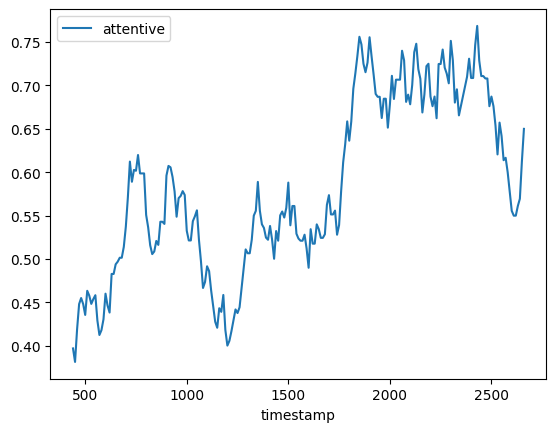

In [48]:
attention_ma = attention_sec.rolling(window=10).mean().dropna()
attention_ma.plot()

<Axes: xlabel='time_group'>

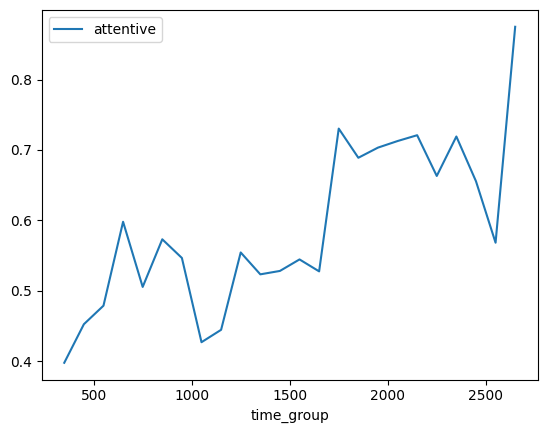

In [49]:
attention_block = attention_df.groupby('time_group')[['attentive']].mean()
attention_block.plot()

### Focus on detection

In [50]:
detection_sec = attention_df.groupby('timestamp').agg(
    {'time_group': 'first',
     'face_idx': 'count'})
# detection_sec.plot(y='attentive', use_index=True)

<Axes: xlabel='timestamp'>

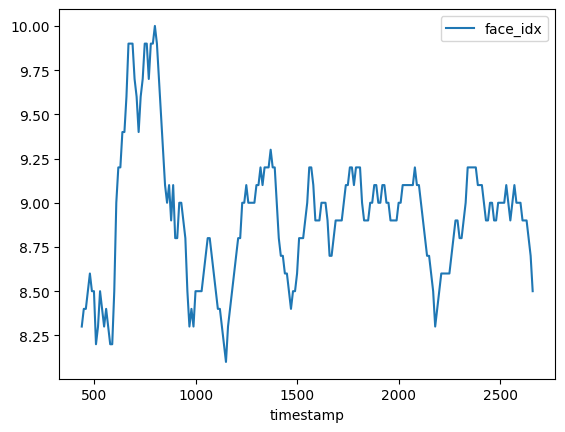

In [51]:
detection_ma = detection_sec.rolling(window=10).mean().dropna()
detection_ma.plot(y='face_idx', use_index=True)

<Axes: xlabel='time_group'>

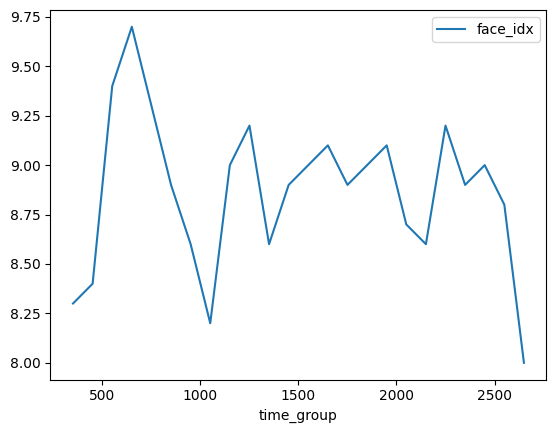

In [52]:
detection_block = detection_sec.groupby('time_group')[['face_idx']].mean()
detection_block.plot(y='face_idx', use_index=True)

### Focus on recognition

#### Number of people recognized

In [53]:
recognition_sec = attention_df.groupby(by='timestamp').agg(
    {'time_group': 'first',
     'recognition_prediction': lambda x: sum(~pd.isna(x))})
# recognition_sec.plot(y='recognition_prediction', use_index=True)

<Axes: xlabel='timestamp'>

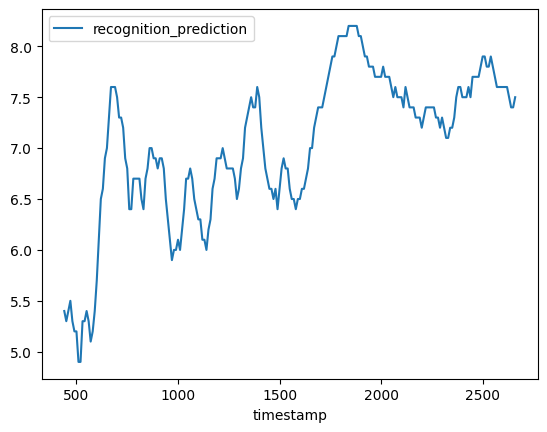

In [54]:
recognition_ma = recognition_sec.rolling(window=10).mean().dropna()
recognition_ma.plot(y='recognition_prediction', use_index=True)

<Axes: xlabel='time_group'>

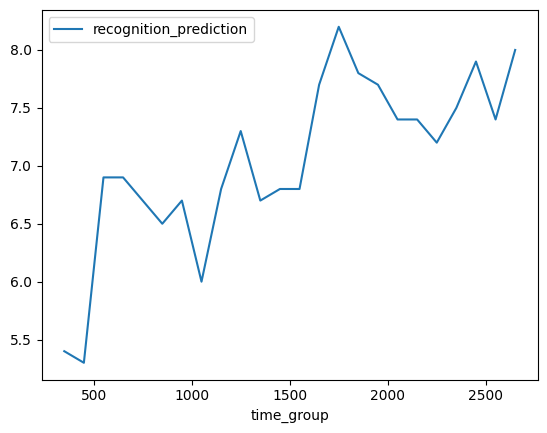

In [55]:
recognition_block = recognition_sec.groupby('time_group')[['recognition_prediction']].mean()
recognition_block.plot(y='recognition_prediction', use_index=True)

#### % people recognized (on detected)

<Axes: xlabel='timestamp'>

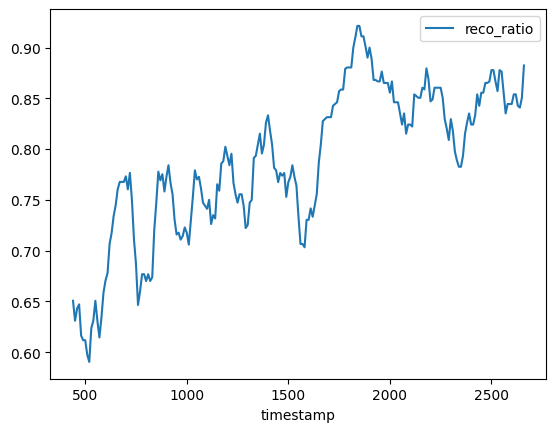

In [56]:
recognized_from_detected_ma = (recognition_ma['recognition_prediction'] / detection_ma['face_idx']).to_frame('reco_ratio')
recognized_from_detected_ma.plot()

## Individual metrics

In [65]:
target_person = 'Lancelot'
person_mask = attention_df['recognition_prediction'] == target_person

In [66]:
# Creating a dataframe with all timestamps available even if person is not recognized
time_df = attention_df[['timestamp', 'time_group']].drop_duplicates()
person_filter_df = attention_df[person_mask].drop(columns='time_group')
person_df = pd.merge(time_df, person_filter_df, how='left', on='timestamp').set_index('timestamp')

### Detection/ Recognition

<Axes: xlabel='timestamp'>

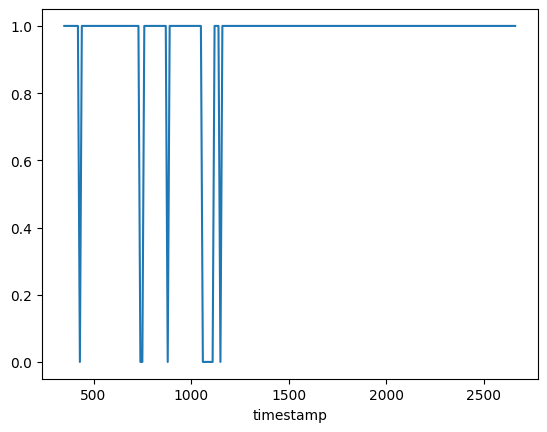

In [67]:
person_detection_sec = (~person_df['recognition_prediction'].isna()) * 1
person_detection_sec.plot()

<Axes: xlabel='timestamp'>

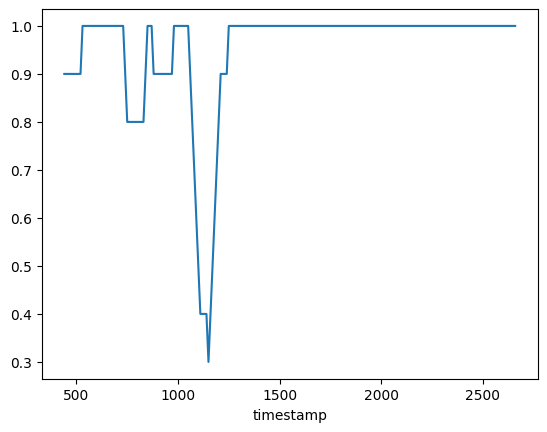

In [68]:
person_detection_ma = person_detection_sec.rolling(window=10).mean().dropna()
person_detection_ma.plot()

### Attention

In [69]:
person_attention_sec = person_df[['time_group', 'attentive']] * 1
# person_attention_sec.plot(y='attentive', use_index=True)

In [70]:
def average_nan(s: pd.Series, threshold: float = 0.4):
    na_rate = s.isna().sum() / len(s)
    return s.mean().round(2) if na_rate <= threshold else np.nan

<Axes: xlabel='time_group'>

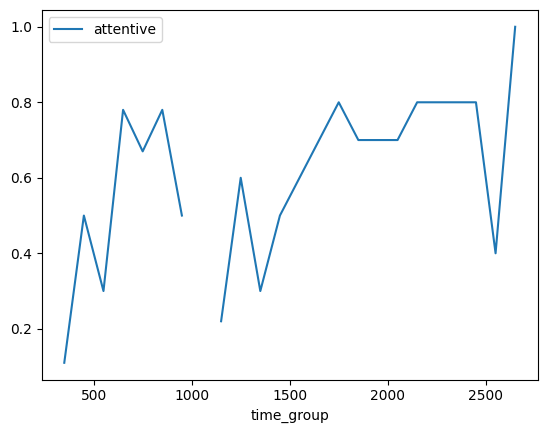

In [71]:
person_attention_block = person_attention_sec.groupby('time_group').agg(
    {'attentive': lambda s: average_nan(s, 0.3)}) 

person_attention_block.plot()